# Instalacion de librerias

In [ ]:
!pip install jellyfish
!pip install bertopic
!pip install fuzzywuzzy
!pip install ydata-profiling

# Importación de Paqueterías

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jellyfish as jf
import nltk
import re

from ydata_profiling import ProfileReport
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from bertopic import BERTopic
from scipy.cluster import hierarchy as sch
from umap import UMAP
from hdbscan import HDBSCAN
from wordcloud import WordCloud
from fuzzywuzzy import process
from nltk.corpus import stopwords
nltk.download('stopwords')

pd.options.display.max_rows = 9999
pd.set_option("display.max_columns", None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Definición de Funciones

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_n_words(corpus, direction, n):
    stop_words_es = ['el', 'la', 'los', 'las', 'de', 'del', 'que', 'y', 'a', 'en', 'un', 'una', 'para', 'por', 'con']
    vec = CountVectorizer(stop_words = stop_words_es).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    if direction == "top":
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    else:
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=False)
    return words_freq[:n]

In [ ]:
def remove_stopwords(text):
    stop_words = ['el', 'la', 'los', 'las', 'de', 'del', 'que', 'y', 'a', 'en', 'un', 'una', 'para', 'por', 'con']
    words = text.split()
    clean_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(clean_words)

# Importación de datos

In [ ]:
df = pd.read_csv('/data_materials.csv')
df.head()

EMATN       MATNR  MATNR_ekbe_1  Material_mbew_1  \
0  11617692.0  11617692.0    11617692.0       11617692.0   
1  11053368.0  11053368.0    11053368.0       11053368.0   
2  11663824.0  11663824.0    11663824.0       11663824.0   
3   3041702.0   3041702.0           NaN              NaN   
4   3013747.0   3013747.0           NaN              NaN   

                                      TXZ01   Denominacion_2_del_gr_articulos  \
0                           SUBSCRIBERS HYS           SERVICIOS PROFESIONALES   
1              COMISION PROGRAMA DE LEALTAD           SERVICIOS PROFESIONALES   
2                      SERVICIO CONSULTORIA                             OTROS   
3   PAPEL HIGIENICO COTTONELLE 40/180 HOJAS  PRODUCTOS DE PAPEL PARA EL HOGAR   
4  BLANQUEADOR MULTIEMPAQUE       15  500 M           CLOROS Y DESINFECTANTES   

  Denominacion_GrpComp  ITEM TEXT_FOR_ITEM_CAT                    grupo  \
0           EcomMKTyUX   0.0          STANDARD  SERVICIOS PROFESIONALES   
1   Programas de Lealt   0.0          STANDARD  SERVICIOS PROFESIONALES   
2       GstComisprovmp   0.0          STANDARD                      NaN   
3   Higien-Desech-Masc   7.0    STOCK TRANSFER                      NaN   
4   Higien-Desech-Masc   7.0    STOCK TRANSFER                      NaN   

          categoria_de_compra sub_categoria_de_compra  \
0  PUBLICIDAD Y MERCADOTECNIA       MEDIOS Y ANUNCIOS   
1  PUBLICIDAD Y MERCADOTECNIA             PROMOCIONES   
2                         NaN                     NaN   
3                         NaN                     NaN   
4                         NaN                     NaN   

                           modelo_de_compra  
0          SERVICIOS CON TARIFAS PERIODICAS  
1  SERVICIOS PROFESIONALES Y ESPECIALIZADOS  
2                                       NaN  
3                                       NaN  
4                                       NaN

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44791 entries, 0 to 44790
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   EMATN                            44789 non-null  float64
 1   MATNR                            44789 non-null  float64
 2   MATNR_ekbe_1                     33917 non-null  float64
 3   Material_mbew_1                  13375 non-null  float64
 4   TXZ01                            44788 non-null  object 
 5   Denominacion_2_del_gr_articulos  44786 non-null  object 
 6   Denominacion_GrpComp             44791 non-null  object 
 7   ITEM                             44789 non-null  float64
 8   TEXT_FOR_ITEM_CAT                44789 non-null  object 
 9   grupo                            10343 non-null  object 
 10  categoria_de_compra              10343 non-null  object 
 11  sub_categoria_de_compra          10312 non-null  object 
 12  modelo_de_compra  

# Procesamiento de Datos

In [ ]:
df['TXZ01'].duplicated(keep=False).value_counts()

True     28649
False    16142
Name: TXZ01, dtype: int64

In [ ]:
df['EMATN'].duplicated(keep=False).value_counts()

True     32629
False    12162
Name: EMATN, dtype: int64

In [ ]:
material = df.drop_duplicates(subset=['EMATN'], keep=False)
material.shape

(12162, 13)

In [ ]:
material.isnull().sum().sort_values(ascending=False)

sub_categoria_de_compra            6424
grupo                              6422
categoria_de_compra                6422
modelo_de_compra                   6422
Material_mbew_1                    4684
MATNR_ekbe_1                        968
EMATN                                 0
MATNR                                 0
TXZ01                                 0
Denominacion_2_del_gr_articulos       0
Denominacion_GrpComp                  0
ITEM                                  0
TEXT_FOR_ITEM_CAT                     0
dtype: int64

In [ ]:
# material = material.dropna()
# material.isnull().sum().sort_values(ascending=False)

EMATN                              0
TXZ01                              0
Denominacion_2_del_gr_articulos    0
Denominacion_GrpComp               0
dtype: int64

In [ ]:
categories = len(df['Denominacion_2_del_gr_articulos'].value_counts())
print(f'Numero de categorias {categories}')

Numero de categorias 238


In [ ]:
profile = ProfileReport(df,
                        title="Análisis Exploratorio de Datos Materiales Soriana",
                                dataset={
        "descripción": "Reporte generado con la finalidad de análizar la calidad de los materiales registrados en SAP",
    }

                          )
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_file("Analysis.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df.loc[df['EMATN'] == 0].count()

EMATN                              5714
MATNR                              5714
MATNR_ekbe_1                       4980
Material_mbew_1                       0
TXZ01                              5714
Denominacion_2_del_gr_articulos    5711
Denominacion_GrpComp               5714
ITEM                               5714
TEXT_FOR_ITEM_CAT                  5714
grupo                                 0
categoria_de_compra                   0
sub_categoria_de_compra               0
modelo_de_compra                      0
dtype: int64

In [ ]:
df['EMATN'].duplicated().value_counts()

True     24936
False    19855
Name: EMATN, dtype: int64

In [ ]:
non_duplicated = df.drop_duplicates(subset=['EMATN'])
non_duplicated.shape

(19855, 13)

In [ ]:
material = df.drop_duplicates(subset=['EMATN'], keep=False)
material.shape

(12162, 13)

In [ ]:
stop_words = set(stopwords.words('spanish') +
                 ['el', 'la', 'los', 'las', 'de', 'del', 'que', 'y', 'a', 'en', 'un', 'una', 'para', 'por', 'con'])

material['TXZ01'] = material['TXZ01'].apply(lambda x: remove_stopwords(x))

In [ ]:
material['material_clean'] = material['TXZ01'].str.lower()

material.head()

EMATN       MATNR  MATNR_ekbe_1  Material_mbew_1  \
0   11617692.0  11617692.0    11617692.0       11617692.0   
1   11053368.0  11053368.0    11053368.0       11053368.0   
2   11663824.0  11663824.0    11663824.0       11663824.0   
4    3013747.0   3013747.0           NaN              NaN   
69  11548809.0  11548809.0    11548809.0       11548809.0   

                                TXZ01       Denominacion_2_del_gr_articulos  \
0                     SUBSCRIBERS HYS               SERVICIOS PROFESIONALES   
1           COMISION PROGRAMA LEALTAD               SERVICIOS PROFESIONALES   
2                SERVICIO CONSULTORIA                                 OTROS   
4   BLANQUEADOR MULTIEMPAQUE 15 500 M               CLOROS Y DESINFECTANTES   
69                      LICENCIA 2020  PARTES Y REFACCIONES EQ DE SEGURIDAD   

   Denominacion_GrpComp  ITEM TEXT_FOR_ITEM_CAT  \
0            EcomMKTyUX   0.0          STANDARD   
1    Programas de Lealt   0.0          STANDARD   
2        GstComisprovmp   0.0          STANDARD   
4    Higien-Desech-Masc   7.0    STOCK TRANSFER   
69         SOD Sistemas   0.0          STANDARD   

                             grupo                     categoria_de_compra  \
0          SERVICIOS PROFESIONALES              PUBLICIDAD Y MERCADOTECNIA   
1          SERVICIOS PROFESIONALES              PUBLICIDAD Y MERCADOTECNIA   
2                              NaN                                     NaN   
4                              NaN                                     NaN   
69  ACTIVOS E INVERSIONES EN CURSO  EQUIPO DE COMPUTO Y TELECOMUNICACIONES   

           sub_categoria_de_compra                          modelo_de_compra  \
0                MEDIOS Y ANUNCIOS          SERVICIOS CON TARIFAS PERIODICAS   
1                      PROMOCIONES  SERVICIOS PROFESIONALES Y ESPECIALIZADOS   
2                              NaN                                       NaN   
4                              NaN                                       NaN   
69  ACTIVOS E INVERSIONES EN CURSO                       MOBILIARIO Y EQUIPO   

                       material_clean  
0                     subscribers hys  
1           comision programa lealtad  
2                servicio consultoria  
4   blanqueador multiempaque 15 500 m  
69                      licencia 2020

In [ ]:
txt = material['material_clean'].to_list()
txt[:5]

['subscribers hys',
 'comision programa lealtad',
 'servicio consultoria',
 'blanqueador multiempaque 15 500 m',
 'licencia 2020']

In [ ]:
txt = [re.sub(r'[^a-zA-Z0-9\s]+', '', x) for x in txt]

In [ ]:
# txt = [str(elemento) for elemento in txt]
# txt = [re.sub(r'[^\w\s]', '', elemento) for elemento in txt]

In [ ]:
txt[:5]

['subscribers hys',
 'comision programa lealtad',
 'servicio consultoria',
 'blanqueador multiempaque 15 500 m',
 'licencia 2020']

In [ ]:
material['material_clean'] = txt
material.head()

EMATN       MATNR  MATNR_ekbe_1  Material_mbew_1  \
0   11617692.0  11617692.0    11617692.0       11617692.0   
1   11053368.0  11053368.0    11053368.0       11053368.0   
2   11663824.0  11663824.0    11663824.0       11663824.0   
4    3013747.0   3013747.0           NaN              NaN   
69  11548809.0  11548809.0    11548809.0       11548809.0   

                                TXZ01       Denominacion_2_del_gr_articulos  \
0                     SUBSCRIBERS HYS               SERVICIOS PROFESIONALES   
1           COMISION PROGRAMA LEALTAD               SERVICIOS PROFESIONALES   
2                SERVICIO CONSULTORIA                                 OTROS   
4   BLANQUEADOR MULTIEMPAQUE 15 500 M               CLOROS Y DESINFECTANTES   
69                      LICENCIA 2020  PARTES Y REFACCIONES EQ DE SEGURIDAD   

   Denominacion_GrpComp  ITEM TEXT_FOR_ITEM_CAT  \
0            EcomMKTyUX   0.0          STANDARD   
1    Programas de Lealt   0.0          STANDARD   
2        GstComisprovmp   0.0          STANDARD   
4    Higien-Desech-Masc   7.0    STOCK TRANSFER   
69         SOD Sistemas   0.0          STANDARD   

                             grupo                     categoria_de_compra  \
0          SERVICIOS PROFESIONALES              PUBLICIDAD Y MERCADOTECNIA   
1          SERVICIOS PROFESIONALES              PUBLICIDAD Y MERCADOTECNIA   
2                              NaN                                     NaN   
4                              NaN                                     NaN   
69  ACTIVOS E INVERSIONES EN CURSO  EQUIPO DE COMPUTO Y TELECOMUNICACIONES   

           sub_categoria_de_compra                          modelo_de_compra  \
0                MEDIOS Y ANUNCIOS          SERVICIOS CON TARIFAS PERIODICAS   
1                      PROMOCIONES  SERVICIOS PROFESIONALES Y ESPECIALIZADOS   
2                              NaN                                       NaN   
4                              NaN                                       NaN   
69  ACTIVOS E INVERSIONES EN CURSO                       MOBILIARIO Y EQUIPO   

                       material_clean  
0                     subscribers hys  
1           comision programa lealtad  
2                servicio consultoria  
4   blanqueador multiempaque 15 500 m  
69                      licencia 2020

In [ ]:
material.sample(10)

EMATN       MATNR  MATNR_ekbe_1  Material_mbew_1  \
27468  11501101.0  11501101.0    11501101.0       11501101.0   
2389   11505010.0  11505010.0    11505010.0       11505010.0   
37766   6260148.0   6260148.0     6260148.0        6260148.0   
33646  11650461.0  11650461.0    11650461.0       11650461.0   
12569  11419013.0  11419013.0    11419013.0       11419013.0   
20422   6254821.0   6254821.0     6254821.0              NaN   
22804  11671773.0  11671773.0    11671773.0       11671773.0   
1714   11552410.0  11552410.0    11552410.0       11552410.0   
4944   11153427.0  11153427.0    11153427.0       11153427.0   
41952  11684487.0  11684487.0    11684487.0              NaN   

                                          TXZ01  \
27468                    Telefonia CEDIS CAPLAN   
2389          CABALLETE TROVICEL 3 mm 8 x 30 cm   
37766  EMPAQUE 17-44126-00 CABEZA LAT DESCARGAD   
33646               PAGO SDV PROYECTOS SISTEMAS   
12569                           CARGADOR TIPO 1   
20422          ANUNCIO CORAZON SORIANA 2.78 MTS   
22804                 2022-DUSTER-Q122798-1994S   
1714   HPE Proactive Care CTR SVCPROLIANT BL460   
4944   Stopper 30x15cms cartulina Carolina 16pt   
41952             INSTALACIÓN CÁMARA CONGELADOS   

           Denominacion_2_del_gr_articulos Denominacion_GrpComp  ITEM  \
27468              SERVICIOS PROFESIONALES         SOD Sistemas   0.0   
2389                                 OTROS   Programas de Lealt   0.0   
37766  MATTO. CORRECTIVO TRANSPORTE PESADO   Trans CADVilla Ind   0.0   
33646              SERVICIOS PROFESIONALES      SOD Rec Humanos   0.0   
12569  MATTO. CORRECTIVO TRANSPORTE PESADO    Trans CAD Qro Ind   0.0   
20422        LOGOTIPO Y LEYENDA EN FACHADA        Mantenimiento   0.0   
22804                                OTROS   Logistica y Transp   0.0   
1714                  SERVICIOS VARIOS R6%   Sop Técnico Sistem   0.0   
4944                                 OTROS             Impresos   0.0   
41952                 EQUIPO REFRIGERACION   Refrig Comer C y C   0.0   

      TEXT_FOR_ITEM_CAT                           grupo  \
27468          STANDARD  SERVICIOS PUBLICOS Y GENERALES   
2389           STANDARD         SERVICIOS PROFESIONALES   
37766          STANDARD                   MANTENIMIENTO   
33646          STANDARD         SERVICIOS PROFESIONALES   
12569          STANDARD                   MANTENIMIENTO   
20422          STANDARD                             NaN   
22804          STANDARD                  ARRENDAMIENTOS   
1714           STANDARD                   MANTENIMIENTO   
4944           STANDARD    INSUMOS OPERACIÓN Y MERCADEO   
41952          STANDARD                             NaN   

                                 categoria_de_compra  \
27468        SERVICIOS TECNOLOGÍAS DE LA INFORMACIÓN   
2389                      PUBLICIDAD Y MERCADOTECNIA   
37766            SERVICIOS Y GASTOS DE MANTENIMIENTO   
33646  SERVICIOS FINANCIEROS, JURÍDICOS Y NORMATIVOS   
12569            SERVICIOS Y GASTOS DE MANTENIMIENTO   
20422                                            NaN   
22804           ARRENDAMIENTO DE EQUIPO Y TRANSPORTE   
1714              PARTES, REFACCIONES Y HERRAMIENTAS   
4944                      PUBLICIDAD Y MERCADOTECNIA   
41952                                            NaN   

                          sub_categoria_de_compra  \
27468                SERVICIOS TELECOMUNICACIONES   
2389                                  PROMOCIONES   
37766  MANTENIMIENTO FLOTA Y EQUIPO DE TRANSPORTE   
33646                           SEGUROS Y FIANZAS   
12569  MANTENIMIENTO FLOTA Y EQUIPO DE TRANSPORTE   
20422                                         NaN   
22804        ARRENDAMIENTO DE EQUIPO Y TRANSPORTE   
1714           MANTENIMIENTO DE EQUIPO DE COMPUTO   
4944                      ARTICULOS PUBLICITARIOS   
41952                                         NaN   

                                        modelo_de_compra  \
27468                       SE

In [ ]:
material.shape

(12162, 14)

# Exploratorio de Datos

In [ ]:
common_words = get_n_words(material['material_clean'], "top", 15)
rare_words = get_n_words(material['material_clean'], "bottom", 15)

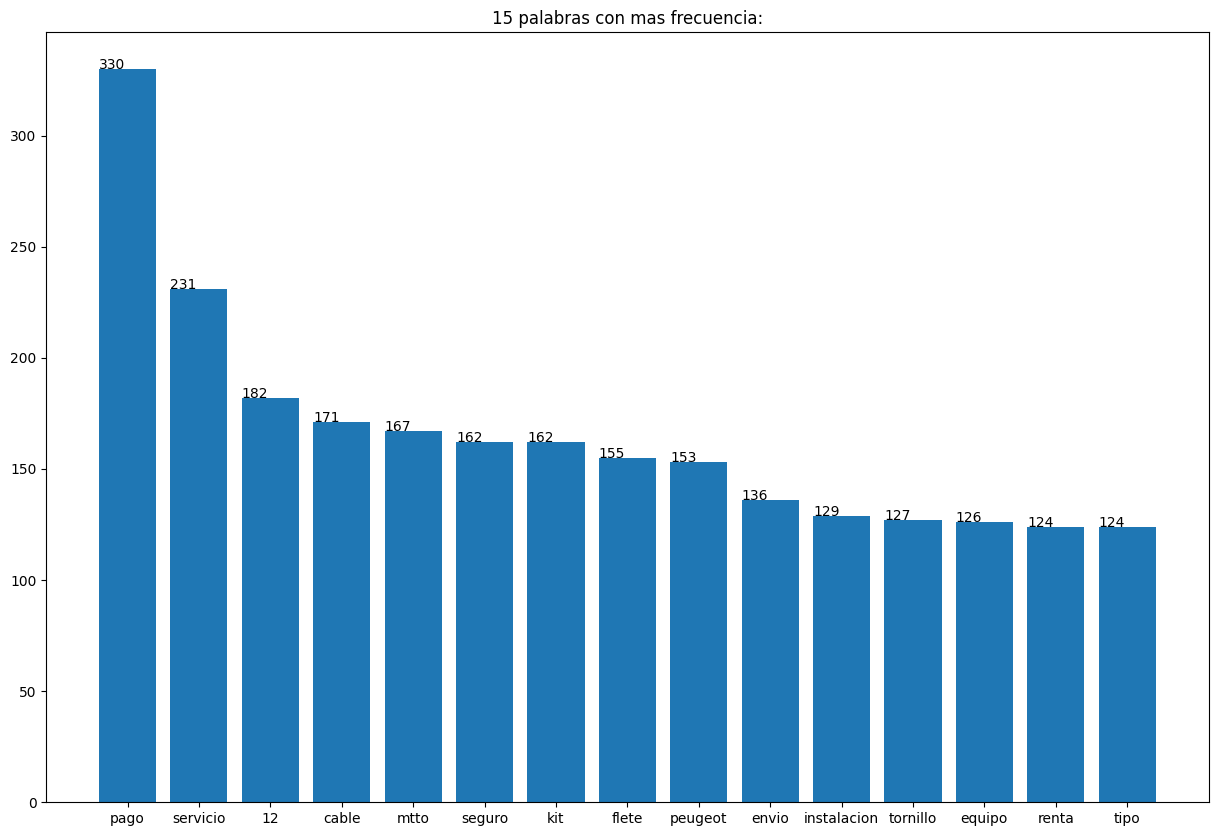

In [ ]:
common_words = dict(common_words)
names = list(common_words.keys())
values = list(common_words.values())
plt.subplots(figsize = (15,10))
bars = plt.bar(range(len(common_words)),values,tick_label=names)
plt.title('15 palabras con mas frecuencia:')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .01, yval)
plt.show()

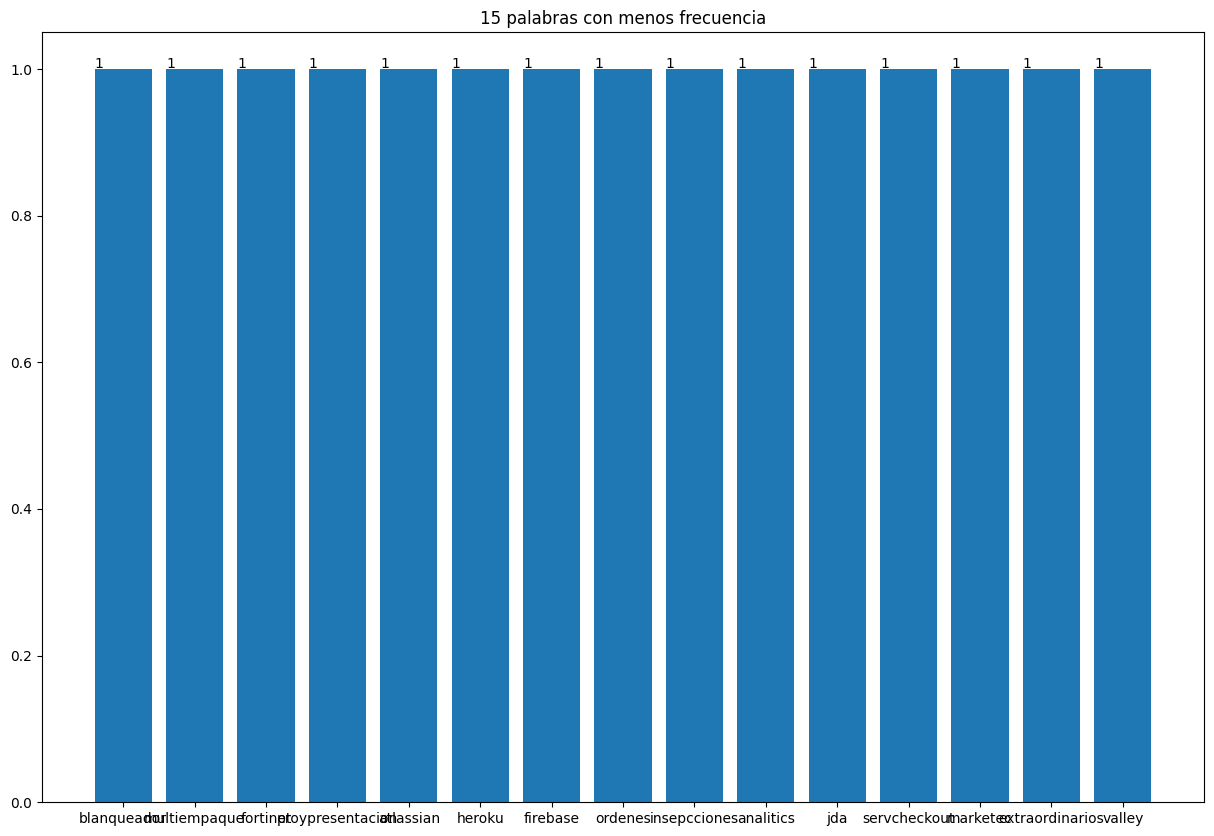

In [ ]:
rare_words = dict(rare_words)
names = list(rare_words.keys())
values = list(rare_words.values())
plt.subplots(figsize = (15,10))
bars = plt.bar(range(len(rare_words)),values,tick_label=names)
plt.title('15 palabras con menos frecuencia')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .001, yval)
plt.show()

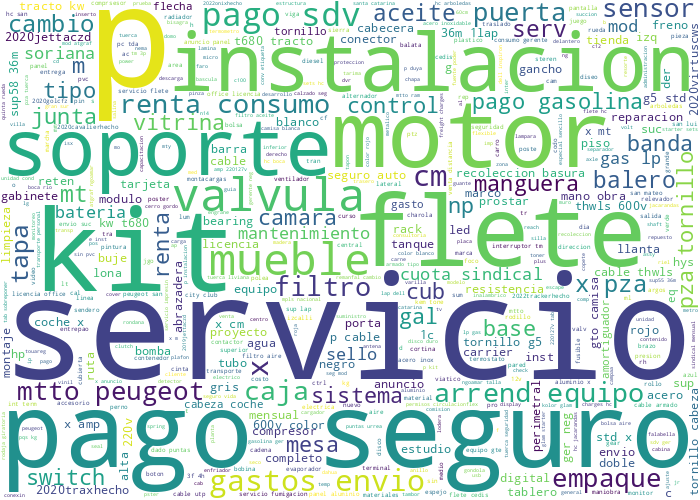

In [ ]:
long_string = ','.join(list(material['material_clean'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, width=700, height=500, contour_width=10, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

Numero de palabras por item

count    12162.000000
mean         3.944088
std          1.722362
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         10.000000
Name: material_clean, dtype: float64


<Axes: >

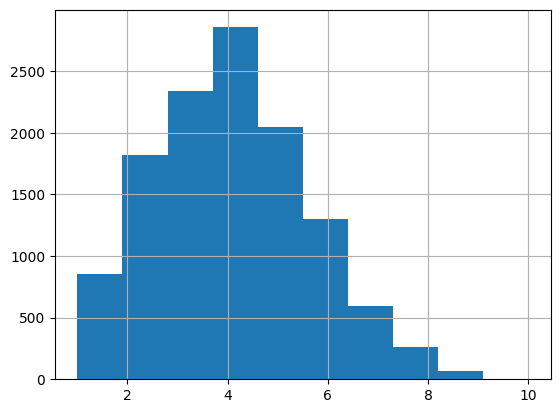

In [ ]:
lens = material['material_clean'].str.split().apply(lambda x: len(x))
print(lens.describe())
lens.hist()

# Modelo topic modeling

In [ ]:
mat_list = material['material_clean'].to_list()

In [ ]:
model = BERTopic(language="multilingual",
                 calculate_probabilities=True,
                 )

topics, probs = model.fit_transform(mat_list)

linkage_function = lambda x: sch.linkage(x, 'centroid', optimal_ordering=True)
distance_function = lambda x: np.abs(1 - cosine_similarity(x))

In [ ]:
hierarchical_topics = model.hierarchical_topics(
                                                    mat_list,
                                                    linkage_function=linkage_function,
                                                    distance_function=distance_function
                                                    )

100%|██████████| 285/285 [00:05<00:00, 50.86it/s]


In [ ]:
hierarchical_topics.head()

Parent_ID                                        Parent_Name Topics  \
284       570  2020versahr16994133t852_2020versahr16978069t87...  [285]   
283       569  2021forteg4nhme4447361571s_2021forteg4nhme4422...  [267]   
282       568  2021forteg4nhme4447361571s_2021forteg4nhme4422...  [267]   
281       567  2020riog4fgle0206361117_2020riog4fgle006507959...  [230]   
280       566  2020riog4fgle0206361117_2020riog4fgle006507959...  [230]   

    Child_Left_ID                                    Child_Left_Name  \
284           285  2020versahr16994133t852_2020versahr16978069t87...   
283           568  2021forteg4nhme4447361571s_2021forteg4nhme4422...   
282           267  2021forteg4nhme4447361571s_2021forteg4nhme4422...   
281           566  2020riog4fgle0206361117_2020riog4fgle006507959...   
280           230  2020riog4fgle0206361117_2020riog4fgle006507959...   

    Child_Right_ID                                   Child_Right_Name  \
284            569  2021forteg4nhme4447361571s_2021forteg4nhme4422...   
283            276  2021sportageg4nalw6406591258s_2021sportageg4na...   
282            567  2020riog4fgle0206361117_2020riog4fgle006507959...   
281            258  2019jettaczd_924592542s_924576545s_924550553s_...   
280            565  2020kickshr16206424v1233s_2020kickshr16891062t...   

     Distance  
284  0.710405  
283  0.710423  
282  0.710442  
281  0.710462  
280  0.710481

In [ ]:
info = model.get_topic_info()
info['Count'].sum()

12162

In [ ]:
info.head()

Topic  Count                                      Name  \
0     -1   3079         -1_flete_soporte_soriana_servicio   
1      0    653         0_peugeot_empaque_rondana_cruceta   
2      1    300                    1_pago_seguro_sdv_auto   
3      2    154  2_gratificacion_campaa_seccionado_hotjar   
4      3    147                  3_cable_armado_cal_hilos   

                                      Representation  \
0  [flete, soporte, soriana, servicio, mts, tipo,...   
1  [peugeot, empaque, rondana, cruceta, valv, jun...   
2  [pago, seguro, sdv, auto, ger, neg, vida, proy...   
3  [gratificacion, campaa, seccionado, hotjar, oj...   
4  [cable, armado, cal, hilos, thw, hdmi, desnudo...   

                                 Representative_Docs  
0  [rampa movil 365 mts rec vert 2do pago, sup 91...  
1  [valv bola 118 emerson abv9, valv bola 58 emer...  
2  [pago sdv ger neg construccion, pago sdv ger n...  
3  [gratificacion arrendamiento falabella, gratif...  
4  [sum tendido cable thw cal 6 3 hilos, cable ar...

In [ ]:
tree = model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─■──2020versahr16994133t852_2020versahr16978069t870_2020versahr16970813t699_2020versahr16970806t778_2020 ── Topic: 285
└─2021forteg4nhme4447361571s_2021forteg4nhme4422741517s_2021forteg4nhme4023711475s_2021forteg4nhme4022
     ├─2021forteg4nhme4447361571s_2021forteg4nhme4422741517s_2021forteg4nhme4023711475s_2021forteg4nhme4022
     │    ├─■──2021forteg4nhme4447361571s_2021forteg4nhme4422741517s_2021forteg4nhme4023711475s_2021forteg4nhme4022 ── Topic: 267
     │    └─2020riog4fgle0206361117_2020riog4fgle006507959_2020riog4fgkh738672516_2020riog4fgkh738115535_2020rio
     │         ├─2020riog4fgle0206361117_2020riog4fgle006507959_2020riog4fgkh738672516_2020riog4fgkh738115535_2020rio
     │         │    ├─■──2020riog4fgle0206361117_2020riog4fgle006507959_2020riog4fgkh738672516_2020riog4fgkh738115535_2020rio ── Topic: 230
     │         │    └─2020kickshr16206424v1233s_2020kickshr16891062t895s_2020kickshr16919523t854s_2020kickshr16917910t704s
     │         │         ├─2020kickshr16206

In [ ]:
model.visualize_hierarchy(hierarchical_topics=hierarchical_topics,
                          linkage_function=linkage_function,
                            distance_function=distance_function
                          )

In [ ]:
model.get_topic(0)

[('peugeot', 0.013522278158079272),
 ('empaque', 0.010886586988399671),
 ('rondana', 0.010654064023729027),
 ('cruceta', 0.009864196435821756),
 ('valv', 0.009400515379600904),
 ('junta', 0.009383611957057936),
 ('plafon', 0.009335028211197477),
 ('seal', 0.009229969352828566),
 ('tuerca', 0.008946273400932495),
 ('tapa', 0.008833426214180155)]

In [ ]:
model.get_representative_docs(0)

['valv bola 118 emerson abv9',
 'valv bola 58 emerson abv5',
 'empaque 4026507 tapa val cummins']

In [ ]:
model.get_topic(0, full=True)

{'Main': [('peugeot', 0.013522278158079272),
  ('empaque', 0.010886586988399671),
  ('rondana', 0.010654064023729027),
  ('cruceta', 0.009864196435821756),
  ('valv', 0.009400515379600904),
  ('junta', 0.009383611957057936),
  ('plafon', 0.009335028211197477),
  ('seal', 0.009229969352828566),
  ('tuerca', 0.008946273400932495),
  ('tapa', 0.008833426214180155)]}

In [ ]:
model.get_topic(1)

[('pago', 0.07447820171824782),
 ('seguro', 0.07044359938723622),
 ('sdv', 0.06966903548894572),
 ('auto', 0.04143945712745091),
 ('ger', 0.035597393325749266),
 ('neg', 0.028781878850711463),
 ('vida', 0.02660307967636681),
 ('proyectos', 0.014489876226165859),
 ('admin', 0.014446365787972676),
 ('mad', 0.01394583189712967)]

In [ ]:
model.get_representative_docs(1)

['pago sdv ger neg construccion',
 'pago sdv ger neg pintura',
 'pago seguro auto ger neg construccion']

In [ ]:
model.visualize_barchart(top_n_topics=12)

In [ ]:
model.visualize_topics()

In [ ]:
model.visualize_heatmap(top_n_topics=20)

In [ ]:
model.visualize_hierarchy(top_n_topics=20)

In [ ]:
model.get_representative_docs(1)

['pago sdv ger neg construccion',
 'pago sdv ger neg pintura',
 'pago seguro auto ger neg construccion']

In [ ]:
model.get_topic(1)

[('pago', 0.07447820171824782),
 ('seguro', 0.07044359938723622),
 ('sdv', 0.06966903548894572),
 ('auto', 0.04143945712745091),
 ('ger', 0.035597393325749266),
 ('neg', 0.028781878850711463),
 ('vida', 0.02660307967636681),
 ('proyectos', 0.014489876226165859),
 ('admin', 0.014446365787972676),
 ('mad', 0.01394583189712967)]

In [ ]:
model.visualize_documents(mat_list,
                          #reduced_embeddings=reduced_embeddings,
                          hide_document_hover=True,
                          hide_annotations=True)

In [ ]:
model.visualize_term_rank()

In [ ]:
topic_distr, _ = model.approximate_distribution(mat_list)
model.visualize_distribution(topic_distr[1])

In [ ]:
model.get_representative_docs(4)

['2022t cross248411786',
 '2022t crossdbt02972231955',
 '2022t crossdtb0293441952']

# Comparacion de items

In [ ]:
resultado = process.extract('pago',
                material['material_clean'],
                limit=None,
                #scorer=jf.jaro_winkler_similarity,
                )

resultado_df  = pd.DataFrame(resultado, columns=['material', 'score', 'index'])
resultado_df[['material', 'score']].value_counts().to_frame()

0
material                        score    
gastos envio                    45     50
gas lp                          36     30
sindicato                       45     17
recoleccion basura              22     15
medios                          22     13
...                                    ..
envios                          22      1
envios 2                        22      1
envo clubes                     22      1
envo paquetera tda 309gavilanes 45      1
zona flex                       28      1

[11573 rows x 1 columns]

In [ ]:
resultado_df.shape

(12162, 3)

In [ ]:
resultados_filtrados = list(filter(lambda x: x[1] >= 80, resultado))

resultados_filtrados = pd.DataFrame(resultados_filtrados, columns=['material', 'score', 'index'])

resultados_filtrados[['material', 'score']].value_counts().to_csv('tema_2.csv')

In [ ]:
resultados_filtrados.shape

(1885, 3)

In [ ]:
hierarchical_topics.head()

Parent_ID                                        Parent_Name Topics  \
231       464  rsoedifeexttpatoetdsdro_coproparasitoscopia_21...  [196]   
230       463                      seguro_mensajeria_eq_computo_   [91]   
229       462                      seguro_mensajeria_eq_computo_   [91]   
228       461                                  perifoneo_hora___   [10]   
227       460                                  perifoneo_hora___   [10]   

    Child_Left_ID                                    Child_Left_Name  \
231           196  rsoedifeexttpatoetdsdro_coproparasitoscopia_21...   
230           462                      seguro_mensajeria_eq_computo_   
229            91                      seguro_mensajeria_eq_computo_   
228           460                                  perifoneo_hora___   
227            10                                  perifoneo_hora___   

    Child_Right_ID                                   Child_Right_Name  \
231            463                      seguro_mensajeria_eq_computo_   
230            195                residuales_final_extrac_dispo_aguas   
229            461                                  perifoneo_hora___   
228             16                                md_lser_kimpresin__   
227            459  temperaturas_nom015stps2001_eval_nom015stps_ex...   

     Distance  
231  0.714701  
230  0.714760  
229  0.714820  
228  0.714881  
227  0.714942

In [ ]:
model.get_topic_info()

Topic  Count                                               Name  \
0       -1   3079                  -1_flete_soporte_soriana_servicio   
1        0    653                  0_peugeot_empaque_rondana_cruceta   
2        1    300                             1_pago_seguro_sdv_auto   
3        2    154           2_gratificacion_campaa_seccionado_hotjar   
4        3    147                           3_cable_armado_cal_hilos   
5        4    125             4_2022t_paradox_2022onixr_2022ventocls   
6        5    117                          5_cm_pinza_cms_perimetral   
7        6    104                6_tornillo_completo_grado_hexagonal   
8        7    103        7_alternador_hl600_amortiguador_pmezcladora   
9        8    102                       8_valvula_valve_valvulas_r12   
10       9     95              9_sensor_detector_sensores_movimiento   
11      10     88                  10_licencia_office_licencias_2020   
12      11     88                           11_motor_freno_fasco_rpm   
13      12     81  12_instalacion_pvtecgavimpsmsbasc_actualizacio...   
14      13     80                        13_aceite_diesel_oil_filtro   
15      14     78                        14_tubo_conduit_tuberia_tub   
16      15     70                            15_36m_sup58_1lap_sup55   
17      16     67                       16_arrend_equipo_gte_equipos   
18      17     67                 17_conector_conexion_conexin_coloc   
19      18     67                          18_dahua_dvr_domo_canales   
20      19     64           19_foraneo_porta_encurtidos_trifuncional   
21      20     62                       20_aire_bolsa_aerosol_krylon   
22      21     61                           21_peugeot_mtto_035_4533   
23      22     60                  22_gastos_envio_adicionales_gasto   
24      23     58                          23_reflector_6500k_led_t8   
25      24     58                       24_agua_pipas_capacidad_pipa   
26      25     58                    25_tienda_tiendas_gestora_cajas   
27      26     57               26_consumo_renta_impuestos_celulares   
28      27     54  27_2021mg_horometro_2022mg515s4cchgma231272063...   
29      28     53                     28_monitor_pantalla_tv_samsung   
30      29     53        29_reparacin_antibacteriana_grasa_solenoide   
31      30     51             30_bateria_kenwood_baterias_recargable   
32      31     51                       31_gasolina_vta_empresa_pago   
33      32     50                             32_53_flete_48_tijuana   
34      33     50                       33_infantil_bustos_nio_chico   
35      34     48                 34_publicidad_anuncios_siglo_norte   
36      35     48  35_2020traxhecho_2021onixhecho_2019traxhecho_m...   
37      36     48                   36_acero_inox_inoxidable_inserto   
38      37     47                              37_kg_pqs_recarga_ext   
39      38     47  38_electrica_electromecanicos_electrico_electrodo   
40      39     47                           39_tablero_3f_4h_220127v   
41      40     46                    40_contactor_volts_contactos_24   
42      41     44                41_alimentos_tortillas_pan_despacho   
43      42     44                         42_gastos_costo_envo_envio   
44      43     44  43_fisicomecanica_2020tiguanczd_verificacion_2020   
45      44     44                         44_ruta_secos_turnos_camin   
46      45     43           45_2021virtuscws_arren_deka_2021jettaczd   
47      46     43                       46_fusible_amps_amp_fusibles   
48      47     43                      47_panel_paneles_110_120x110m   
49      48     41             48_2022onixhecho_guadalajara_mexico_jr   
50      49     41                    49_llave_pulid_fluxometro_combi   
51      50     41               50_consultoria_sanitaria_bota_medico   
52      51     41                         51_lp_gas_gases_evaluacion   
53      52     41                 52_limpieza_lavado_limpiador_10095   
54      53     40            53_termostato_th